In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
emb_dim = 32
aedpmerf = AEDPMERF(is_priv=True)

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [3]:
model_name = f"lstmae_180_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    aedpmerf.load_ae(model_name)
else:
    model, history = aedpmerf.train_ae()
    plt.plot(history["train"])
    plt.plot(history["val"])
    aedpmerf.save_ae(model_name)

loading AE model from models/lstmae_180_embed32.pth


In [5]:
eps = 0.01
lr = 1e-5
n_epochs = 4000
enc_df = aedpmerf.encode_train_data(train_ds_path="data/normal_train_180.csv", fname=f"data/normal_training_encoded_embed{emb_dim}_eps001.csv")
aedpmerf.train_gen(data=enc_df, mini_batch_size=0.1, lr=lr, eps=eps, n_epochs=n_epochs)
n_gen_samples = enc_df.shape[0]
gen_data = aedpmerf.generate(n_gen_samples, fname=f"enc_gen_priv_embed{emb_dim}_eps001.csv")

saving encoded training data in data/normal_training_encoded_embed32_eps001.csv
minibatch:  6334
total number of datapoints in the training data is 63326
random freq (1000, 32)
adding DP noise
Starting Training
epoch # and running loss are  [0, 9.08380651473999]
epoch # and running loss are  [100, 8.993328988552094]
epoch # and running loss are  [200, 8.67011046409607]
epoch # and running loss are  [300, 5.642062723636627]
epoch # and running loss are  [400, 4.521807789802551]
epoch # and running loss are  [500, 4.273760885000229]
epoch # and running loss are  [600, 4.144096225500107]
epoch # and running loss are  [700, 4.058670848608017]
epoch # and running loss are  [800, 3.9969252943992615]
epoch # and running loss are  [900, 3.95057013630867]
epoch # and running loss are  [1000, 3.9160903990268707]
epoch # and running loss are  [1100, 3.8912301063537598]
epoch # and running loss are  [1200, 3.870754450559616]
epoch # and running loss are  [1300, 3.8536316752433777]
epoch # and runn

In [6]:
pd.DataFrame(gen_data).to_csv(f"data/generated/normal_train_180_embed{emb_dim}_priv001_merf.csv")

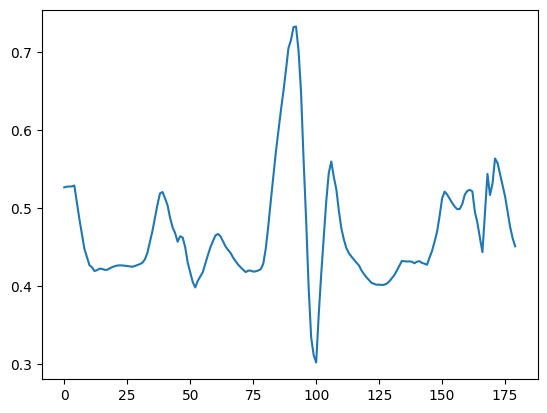

In [7]:
plt.plot(gen_data[3])

In [8]:
ae_gen = AutoEncTrainRoutine()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


loss: 64.958374  [    1/63336]
loss: 25.289383  [10001/63336]
loss: 11.232157  [20001/63336]
loss: 7.355700  [30001/63336]
loss: 10.698862  [40001/63336]
loss: 3.548781  [50001/63336]
loss: 3.166104  [60001/63336]
Epoch 1: train loss = 8.681815572723876, val loss = 7.520174036347145
loss: 3.441102  [    1/63336]
loss: 1.909547  [10001/63336]
loss: 10.431383  [20001/63336]
loss: 3.505774  [30001/63336]
loss: 2.024848  [40001/63336]
loss: 2.753767  [50001/63336]
loss: 1.406971  [60001/63336]
Epoch 2: train loss = 3.604016393213218, val loss = 7.059188130973042
loss: 2.387729  [    1/63336]
loss: 2.341638  [10001/63336]
loss: 2.625067  [20001/63336]
loss: 2.790352  [30001/63336]
loss: 2.114586  [40001/63336]
loss: 2.749828  [50001/63336]
loss: 1.847074  [60001/63336]
Epoch 3: train loss = 2.901515026619989, val loss = 6.3756931855550505
loss: 1.451649  [    1/63336]
loss: 9.540720  [10001/63336]
loss: 2.237458  [20001/63336]
loss: 2.814422  [30001/63336]
loss: 1.685964  [40001/63336]
loss

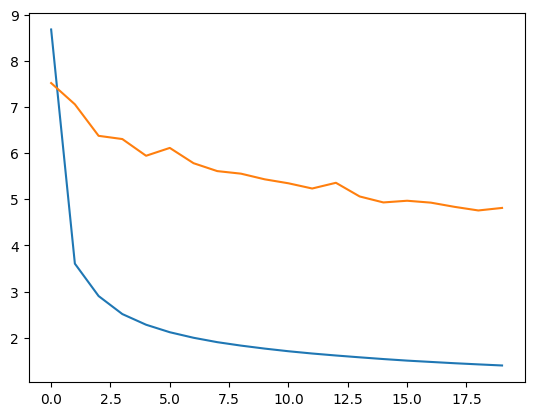

In [9]:
model_name = f"dpmerf_priv001_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path=f"data/generated/normal_train_180_embed{emb_dim}_priv001_merf.csv", val_ds_path="data/normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

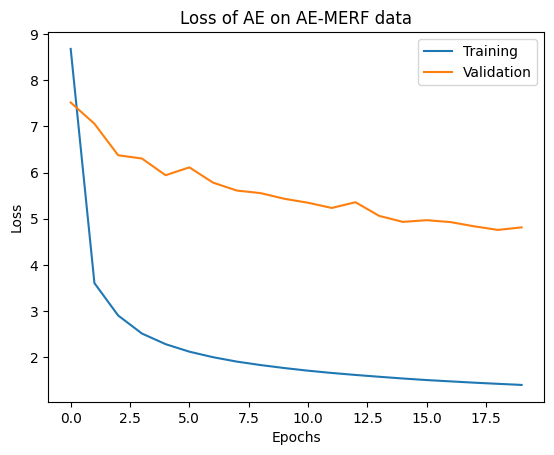

In [10]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title("Loss of AE on AE-MERF data")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
window_size=180
evaluator = Evaluator(val_normal_path=f"data/normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/anomaly_val_{window_size}.csv",
                      val_anomaly_label_path=f"data/anomaly_val_labels_{window_size}.csv",
                      test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        test_anomaly_label_path=f"data/anomalie_labels_{window_size}.csv",
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


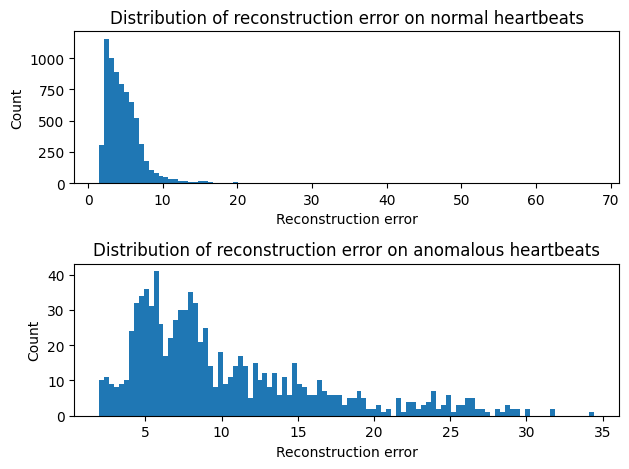

In [12]:
plt.figure()

plt.subplot(2,1,1)
plt.hist(evaluator.loss_val_normal, bins=100)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.title("Distribution of reconstruction error on normal heartbeats")

plt.subplot(2,1,2)
plt.hist(evaluator.loss_val_anomaly, bins=100)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.title("Distribution of reconstruction error on anomalous heartbeats")
plt.tight_layout()

plt.show()

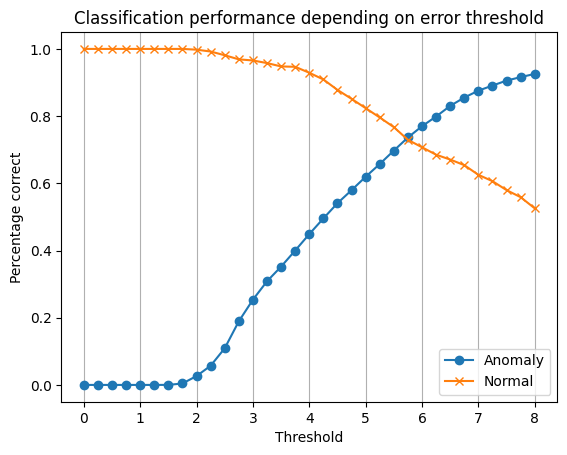

In [16]:
thres_list = np.linspace(0,8,33)
corr_normal, corr_anomaly = evaluator.find_threshold(thres_list)
plt.plot(thres_list, corr_normal, marker="o")
plt.plot(thres_list, corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.title("Classification performance depending on error threshold")
plt.grid(axis="x")
plt.show()

In [15]:
predictions_normal, predictions_anomaly = evaluator.predict_class(5.75)


/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [17]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 12701
FN: 4893
FP: 4528
TN: 12610
Acc: 0.7287515835540712
Precision: 0.7371873004817459
Recall: 0.7218938274411731
F1: 0.7294604140941332
